In [1]:
%matplotlib inline
import os, sys, inspect, warnings
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
main_dir = '/'.join(curr_dir.split('/')[:-1])
sub_dir = os.path.join(main_dir, 'RGCPD/')
# core_pp = os.path.join(main_dir, 'RGCPD/core')
if main_dir not in sys.path:
    sys.path.append(main_dir)
    sys.path.append(sub_dir)
import numpy as np 
from collections import Counter
# import statsmodels.api as sm 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import itertools as it
import pywt as wv
from scipy.fftpack import fft
from copy import deepcopy
# from statsmodels.tsa.arima_process import  arma_generate_sample, ArmaProcess
from pprint import pprint as pp 
from pandas.plotting import register_matplotlib_converters
from RGCPD import RGCPD
from RGCPD import BivariateMI
import core_pp
import plot_signal_decomp
import plot_coeffs
from visualize_cwt import *
register_matplotlib_converters()
np.random.seed(12345)
plt.style.use('seaborn')

Could not import rpy package
Could not import r-package RCIT


In [2]:
path_data = os.path.join(main_dir, 'data')
current_analysis_path = os.path.join(main_dir, 'Jier_analysis')
target= 3
target_path = os.path.join(path_data, 'tf5_nc5_dendo_80d77.nc')
precursor_path = os.path.join(path_data,'sst_1979-2018_2.5deg_Pacific.nc')
list_of_name_path = [(target, target_path), 
                    ('sst', precursor_path )]
list_for_MI = [BivariateMI(name='sst', func=BivariateMI.corr_map, 
                          kwrgs_func={'alpha':.0001, 'FDR_control':True}, 
                          distance_eps=700, min_area_in_degrees2=5)]
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           path_outmain=os.path.join(main_dir,'data'))


In [3]:
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)
rg.pp_TV()
rg.traintest(method='no_train_test_split')
rg.calc_corr_maps()
rg.cluster_list_MI()
rg.get_ts_prec(precur_aggr=1)
rg.get_ts_prec()

Loaded pre-processed data of sst

original tfreq of imported response variable is converted to desired tfreq 10
No train test split

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(320dp, 100%)

redefine target variable on 1 day means
Selecting subset as defined by start_end_date
No train test split

Getting MI timeseries
There are [2] regions in total (list of different splits)

Getting MI timeseries
There are [2] regions in total (list of different splits)


Progress causal inference - traintest set 100%

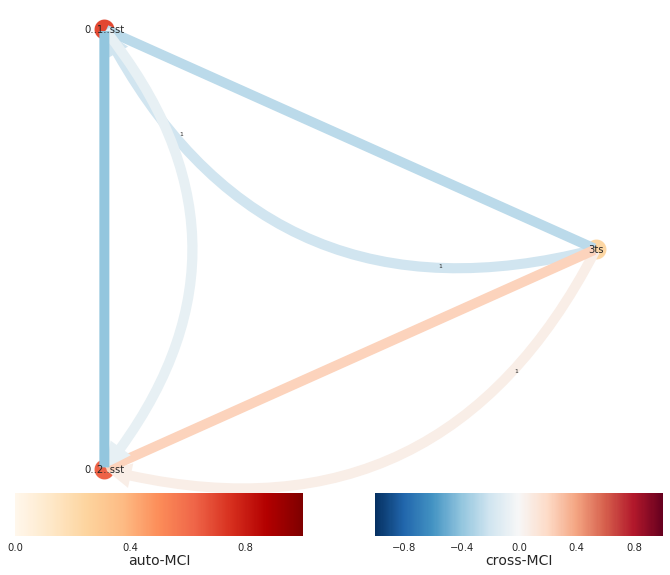

In [4]:
rg.PCMCI_df_data()
rg.PCMCI_get_links()
rg.df_MCIc
rg.PCMCI_plot_graph()

In [5]:
rg_data  = rg.df_data[['3ts', '0..1..sst', '0..2..sst']]
rg_data = rg_data.rename(columns={'0..1..sst':'prec1', '0..2..sst':'prec2'})
rg_index = rg_data.index.levels[1]
prec1 = rg_data['prec1'].values
prec2 = rg_data['prec2'].values
target = rg_data['3ts'].values
wave  = wv.Wavelet('db4')
mode=wv.Modes.periodic

In [6]:
def lowpassfilter(signal, thresh = 0.63, wavelet="haar"):
    thresh = thresh*np.nanmax(signal)
    coeff = wv.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (wv.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = wv.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal



In [7]:
def denoise_high_frequency(signal, thresh, wavelet):
    new_signal = lowpassfilter(signal, thresh, wavelet)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(signal, 'r', alpha=0.5, label='original')
    ax.legend()
    ax.plot(new_signal, 'k', alpha=0.4, label='denoised')
    ax.legend()

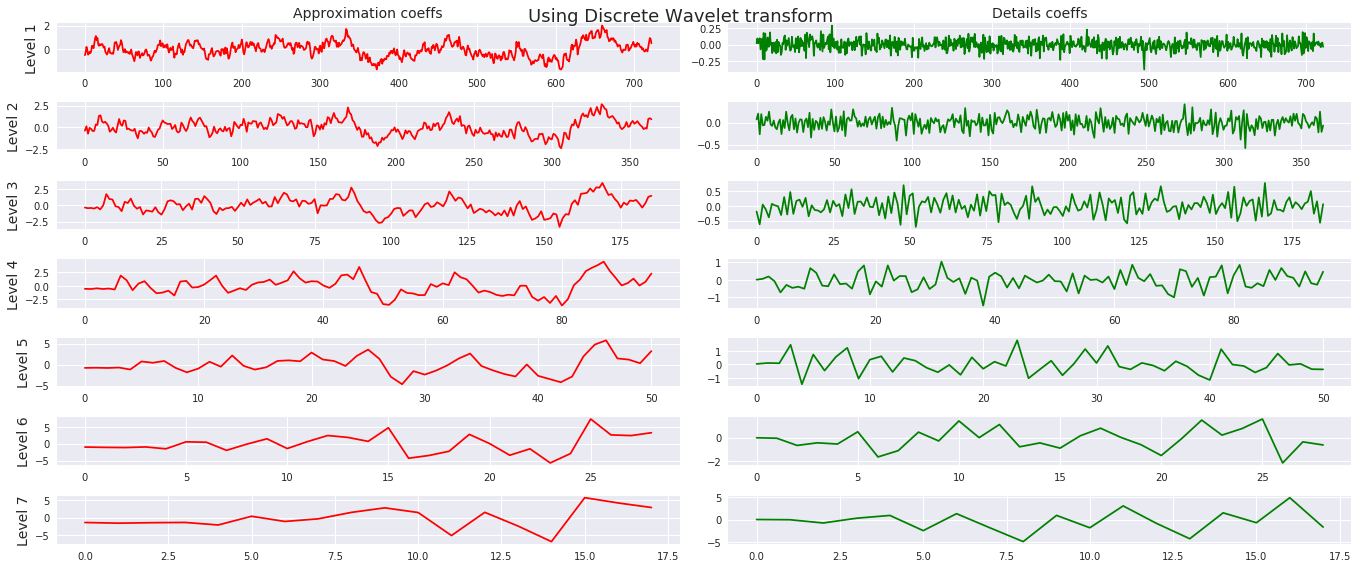

In [8]:
fig, ax = plt.subplots(7, 2, figsize=(19, 8))
fig.suptitle('Using Discrete Wavelet transform', fontsize=18)
ap = rg_data['prec1'].values
for i in range(7):
   ap, det =  wv.dwt(ap, 'db4')
   ax[i, 0].plot(ap, 'r')
   ax[i, 1].plot(det, 'g')
   ax[i, 0].set_ylabel('Level {}'.format(i + 1), fontsize=14, rotation=90)
   if i == 0:
        ax[i, 0].set_title('Approximation coeffs', fontsize=14)
        ax[i, 1].set_title('Details coeffs', fontsize=14)
plt.tight_layout()
plt.show()

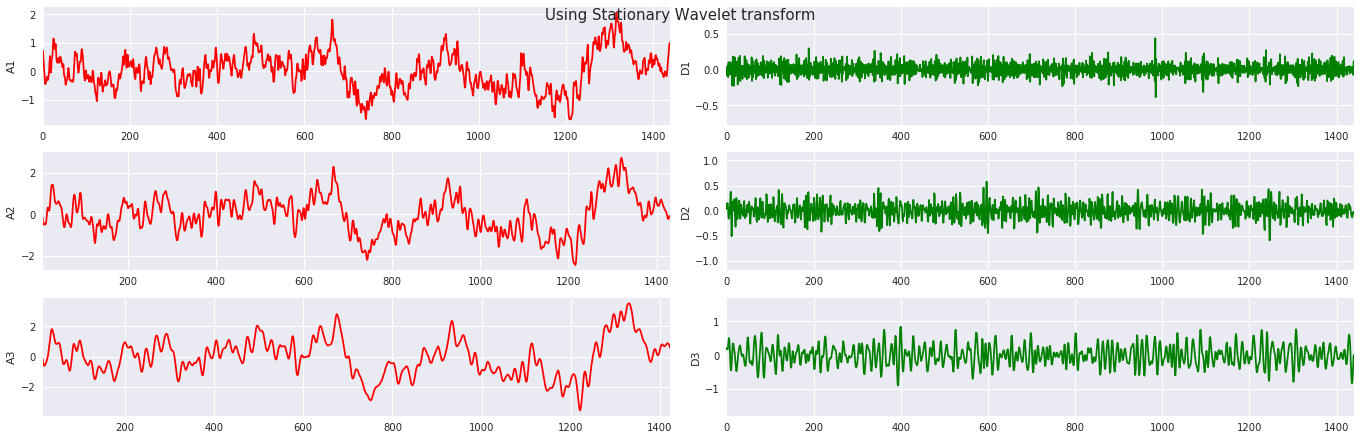

In [9]:
fig = plt.figure(figsize=(19, 8))
fig.suptitle('Using Stationary Wavelet transform', fontsize=15)
a = rg_data['prec1'].values
w  = wv.Wavelet('db4')
coeffs =  wv.swt(a, w, 3)
ca , cd = [], []
for ap, det  in reversed(coeffs):
    ca.append(ap)
    cd.append(det)
for i, x in enumerate(ca):
    ax = fig.add_subplot(len(ca) + 1, 2, 1 + i * 2)
    ax.plot(x, 'r')
    ax.set_ylabel("A%d" % (i + 1))
    ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

for i, x in enumerate(cd):
    ax = fig.add_subplot(len(cd) + 1, 2, 2 + i * 2)
    ax.plot(x, 'g')
    ax.set_ylabel("D%d" % (i + 1))
    # Scale axes
    ax.set_xlim(0, len(x) - 1)
    vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
    ax.set_ylim(min(0, 2 * min(vals)), max(0, 2 * max(vals)))
plt.tight_layout()

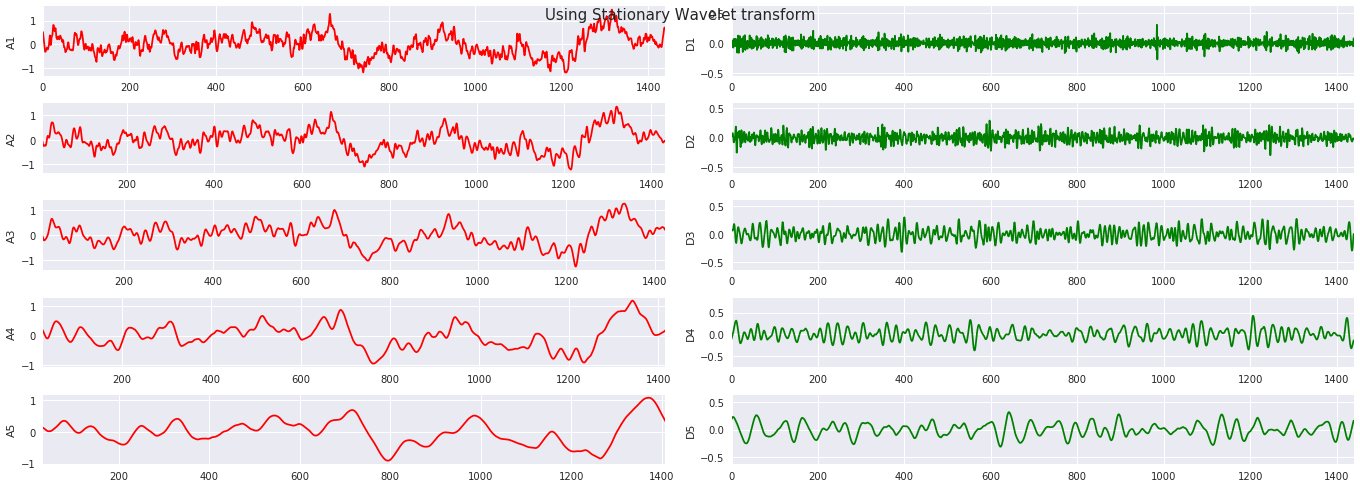

In [10]:
fig = plt.figure(figsize=(19, 8))
fig.suptitle('Using Stationary Wavelet transform', fontsize=15)
a = rg_data['prec1'].values
w  = wv.Wavelet('db4')
coeffs =  wv.swt(a, w, 5,norm=True)
ca , cd = [], []
for ap, det  in reversed(coeffs):
    ca.append(ap)
    cd.append(det)
for i, x in enumerate(ca):
    ax = fig.add_subplot(len(ca) + 1, 2, 1 + i * 2)
    ax.plot(x, 'r')
    ax.set_ylabel("A%d" % (i + 1))
    ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

for i, x in enumerate(cd):
    ax = fig.add_subplot(len(cd) + 1, 2, 2 + i * 2)
    ax.plot(x, 'g')
    ax.set_ylabel("D%d" % (i + 1))
    # Scale axes
    ax.set_xlim(0, len(x) - 1)
    vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
    ax.set_ylim(min(0, 2 * min(vals)), max(0, 2 * max(vals)))
plt.tight_layout()

In [11]:
# Using recursion we obtain all of our approximation coefficients with just dwt
s_prec1 = prec1
cA, cD = [], []
wave  = wv.Wavelet('db4')
for i in range(wv.dwt_max_level(len(s_prec1), wave.dec_len)): # Using recursion to overwrite signal to go level deepeer
   s_prec1, det =  wv.dwt(s_prec1, wave , mode=mode)
   print('Len Sign ', len(s_prec1), 'Lenght detail ', len(det))
   cA.append(s_prec1)
   cD.append(det)
# print('Inspecting approximations length')
for i, c in enumerate(cA):
    print(i, len(c))
# print('Inspecting details length')
# for i, d in enumerate(cD):
#     print(i, len(d))

Len Sign  723 Lenght detail  723
Len Sign  365 Lenght detail  365
Len Sign  186 Lenght detail  186
Len Sign  96 Lenght detail  96
Len Sign  51 Lenght detail  51
Len Sign  29 Lenght detail  29
Len Sign  18 Lenght detail  18
0 723
1 365
2 186
3 96
4 51
5 29
6 18


In [12]:
s_prec2 = prec2
cA_2, cD_2 = [], []
wave  = wv.Wavelet('db4')
for i in range(wv.dwt_max_level(len(s_prec2), wave.dec_len)): # Using recursion to overwrite signal to go level deepeer
   s_prec2, det =  wv.dwt(s_prec2, wave , mode=mode)
   print('Len Sign ', len(s_prec2), 'Lenght detail ', len(det))
   cA_2.append(s_prec2)
   cD_2.append(det)
# print('Inspecting approximations length')
for i, c in enumerate(cA_2):
    print(i, len(c))
# print('Inspecting details length')
# for i, d in enumerate(cD_2):
#     print(i, len(d))

Len Sign  723 Lenght detail  723
Len Sign  365 Lenght detail  365
Len Sign  186 Lenght detail  186
Len Sign  96 Lenght detail  96
Len Sign  51 Lenght detail  51
Len Sign  29 Lenght detail  29
Len Sign  18 Lenght detail  18
0 723
1 365
2 186
3 96
4 51
5 29
6 18


In [13]:
s_target = target
cA_t, cD_t = [], []
wave  = wv.Wavelet('db4')
for i in range(wv.dwt_max_level(len(s_target), wave.dec_len)): # Using recursion to overwrite signal to go level deepeer
   s_target, det =  wv.dwt(s_target, wave , mode=mode)
   print('Len Sign ', len(s_target), 'Lenght detail ', len(det))
   cA_t.append(s_target)
   cD_t.append(det)
# print('Inspecting approximations length')
for i, c in enumerate(cA_t):
    print(i, len(c))
# print('Inspecting details length')
# for i, d in enumerate(cD_t):
#     print(i, len(d))

Len Sign  723 Lenght detail  723
Len Sign  365 Lenght detail  365
Len Sign  186 Lenght detail  186
Len Sign  96 Lenght detail  96
Len Sign  51 Lenght detail  51
Len Sign  29 Lenght detail  29
Len Sign  18 Lenght detail  18
0 723
1 365
2 186
3 96
4 51
5 29
6 18


Progress causal inference - traintest set 100%

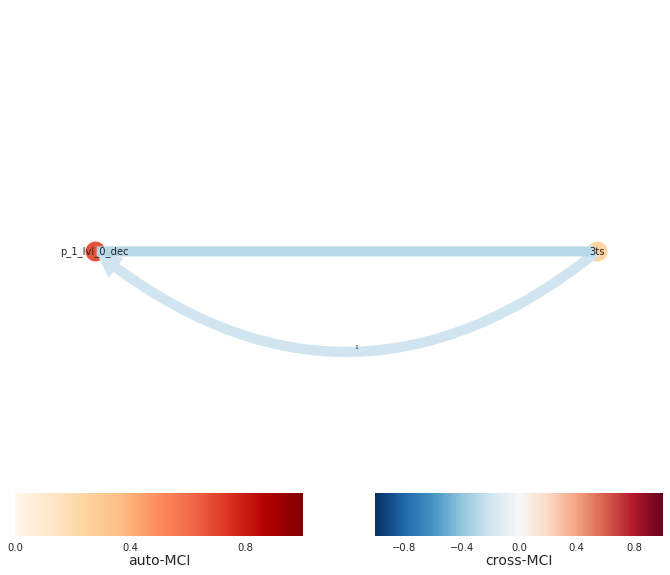

Progress causal inference - traintest set 100%

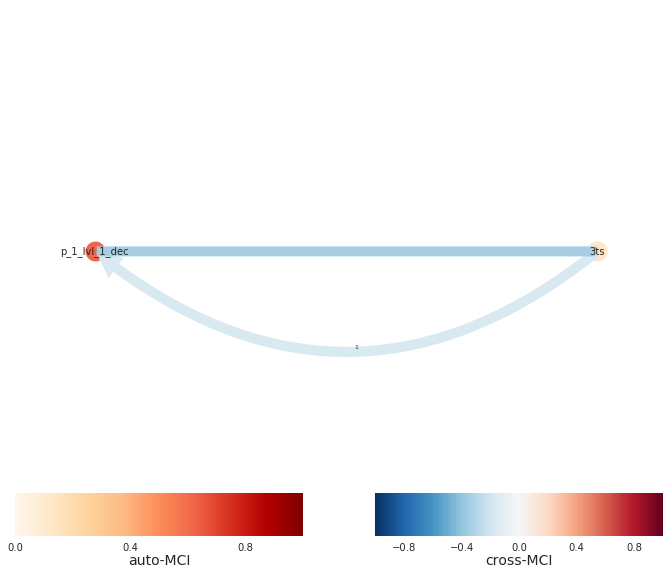

Progress causal inference - traintest set 100%

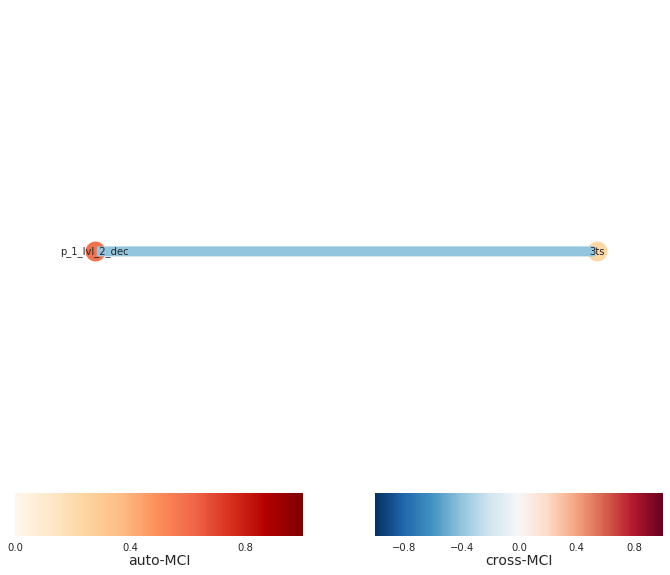

Progress causal inference - traintest set 100%

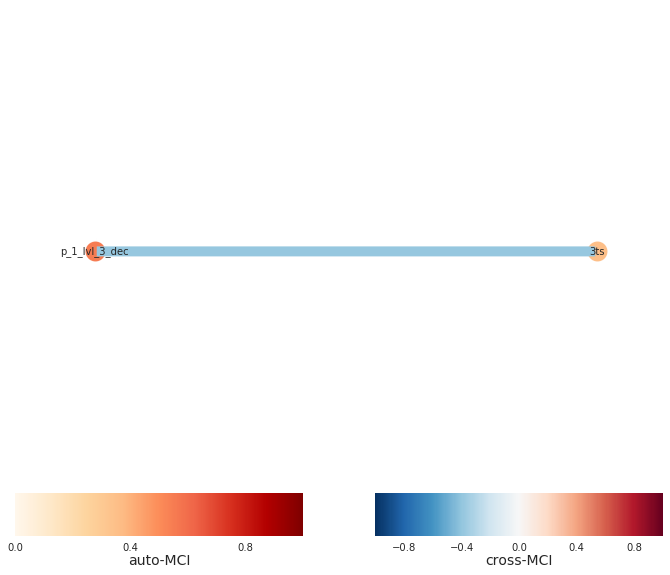

Progress causal inference - traintest set 100%

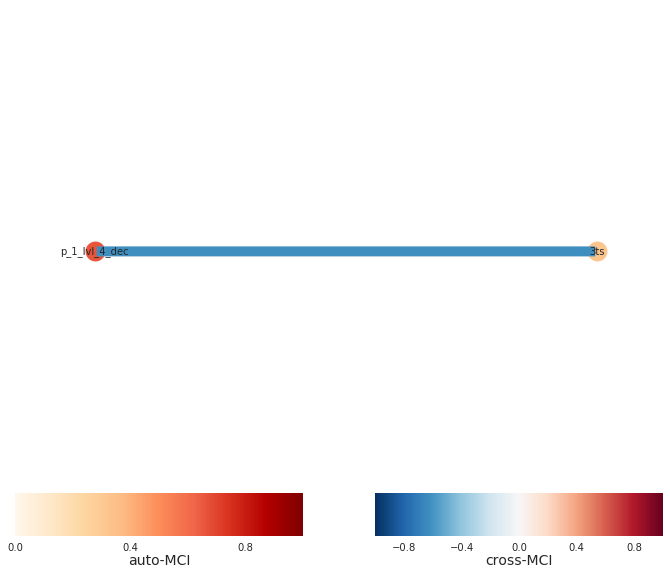

Progress causal inference - traintest set 100%

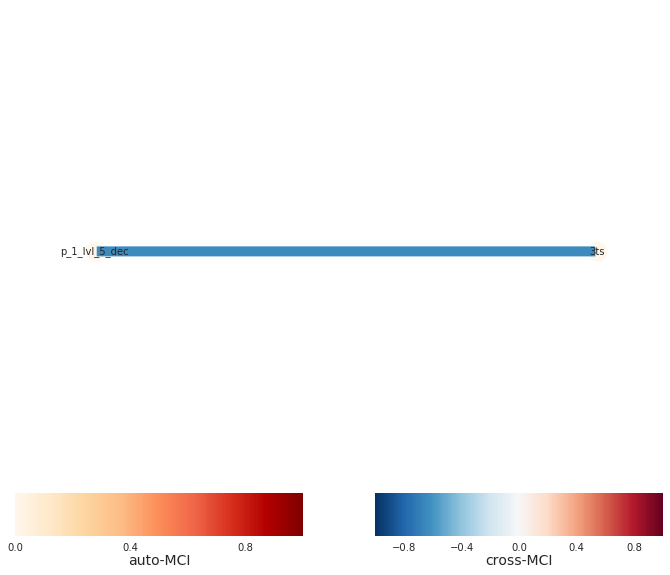

Progress causal inference - traintest set 100%

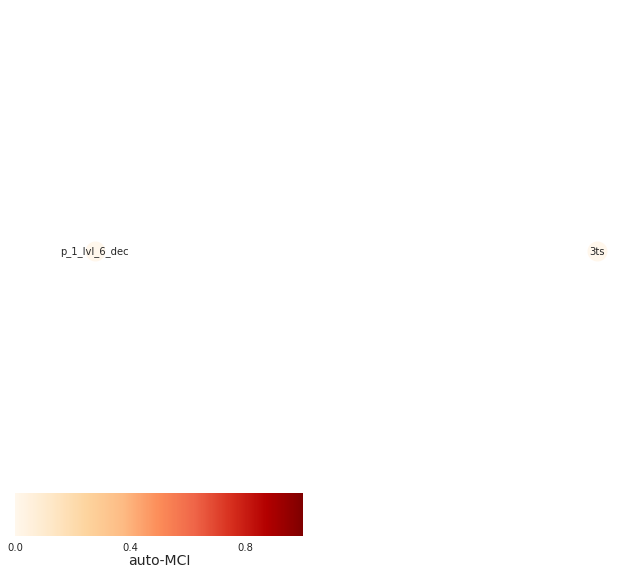

In [14]:
obj_rgcpd = []
for i in range(0,len(cA)):    
    idx_lvl_t = pd.DatetimeIndex(pd.date_range(rg_index[0] ,end=rg_index[-1], periods=len(cA_t[i]) ).strftime('%Y-%m-%d') )
    idx_prec = pd.DatetimeIndex(pd.date_range(rg_index[0], rg_index[-1], periods=len(cA[i]) ).strftime('%Y-%m-%d') )
    dates = core_pp.get_subdates(dates=idx_lvl_t, start_end_date=('06-15', '08-20'), start_end_year=None, lpyr=False)
    full_time  = idx_lvl_t
    RV_time  = dates
    RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='RV_mask')
    trainIsTrue = pd.Series(np.array([True for _ in range(len(cA_t[i]))]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='TrainIsTrue')
    ts_ca1 = pd.Series(cA[i], index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_1_lvl_'+ str(i)+'_dec')
    # ts_ca2= pd.Series(cA_2[i], index=pd.MultiIndex.from_product(([0], idx_prec)), name='p_2_lvl_'+str(i)+'_dec')
    ts_tca1 = pd.Series(cA_t[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
    df = pd.concat([ts_tca1, ts_ca1, trainIsTrue, RV_mask], axis=1)
    rg.df_data = df
    rg.PCMCI_df_data()
    rg.PCMCI_get_links()
    rg.df_MCIc
    obj_rgcpd.append(deepcopy(rg.df_MCIc))
    rg.PCMCI_plot_graph()

In [15]:
clean_mci = obj_rgcpd
x_as = np.arange(0, len(cA))
lag_0 = [np.mean(lags.values[:,0]) for i, lags in enumerate(clean_mci)]
lag_1 = [np.mean(lags.values[:,1]) for _, lags in enumerate(clean_mci)]

In [16]:
# plt.figure(figsize=(19,8))
# plt.plot(x_as, lag_0, 'r', label='MCI mean on lag 0')
# plt.plot(x_as, lag_1, 'g', label='MCI mean on lag 1')
# plt.title('Relation MCI on scale wavelet')
# plt.xlabel('Scales')
# plt.ylabel('MCI')
# plt.legend(loc=0)
# plt.show()

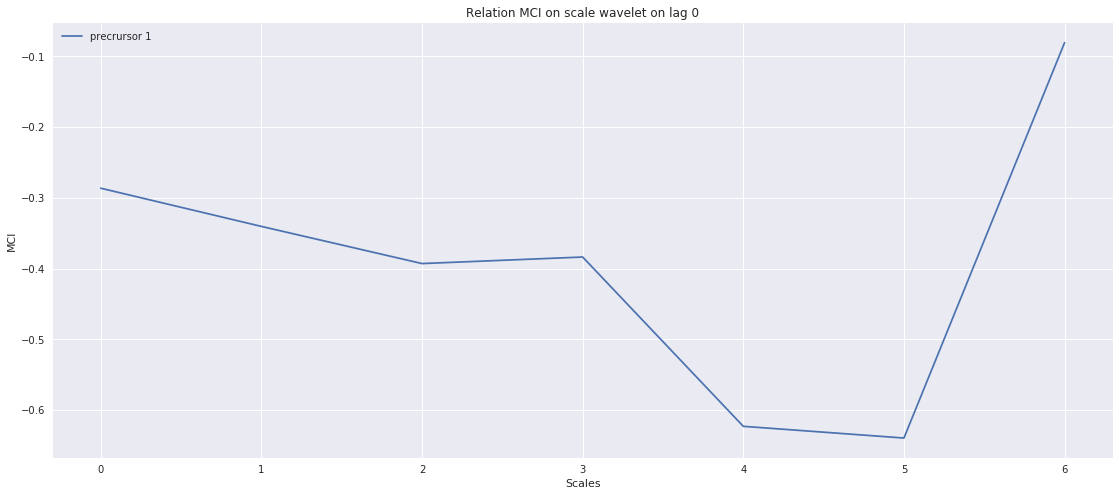

In [17]:
# lag_0_t = [lags.values[:,0][0] for _, lags in enumerate(clean_mci)]
lag_0_1 = [lags.values[:,0][1] for _, lags in enumerate(clean_mci)]

plt.figure(figsize=(19,8))
# plt.plot(x_as, lag_0_t, label='target ')
plt.plot(x_as, lag_0_1, label='precrursor 1 ')
plt.title('Relation MCI on scale wavelet on lag 0')
plt.xlabel('Scales')
plt.ylabel('MCI')
plt.legend(loc=0)
plt.show()

In [18]:
# lag_1_t = [lags.values[:,1][0] for _, lags in enumerate(clean_mci)]
# lag_1_1 = [lags.values[:,1][1] for _, lags in enumerate(clean_mci)]
# plt.figure(figsize=(19,8))
# plt.plot(x_as, lag_1_t, label='target ')
# plt.plot(x_as, lag_1_1, label='precrursor 1 ')
# plt.title('Relation MCI on scale wavelet on lag 1')
# plt.xlabel('Scales')
# plt.ylabel('MCI')
# plt.legend(loc=0)
# plt.show()

Progress causal inference - traintest set 100%

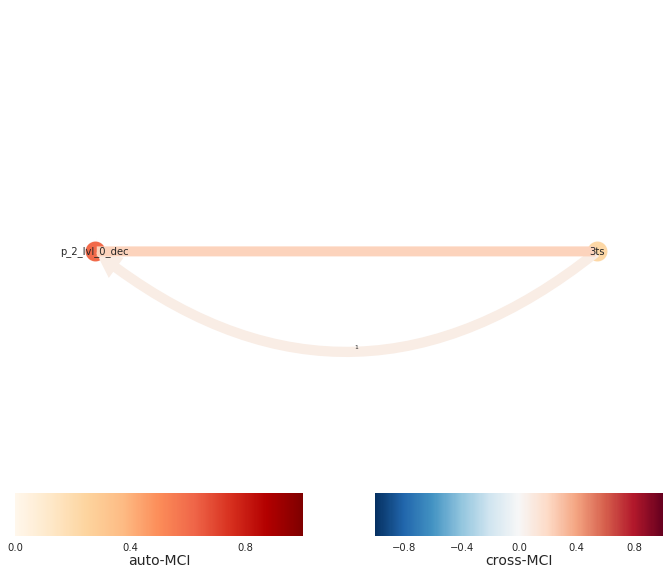

Progress causal inference - traintest set 100%

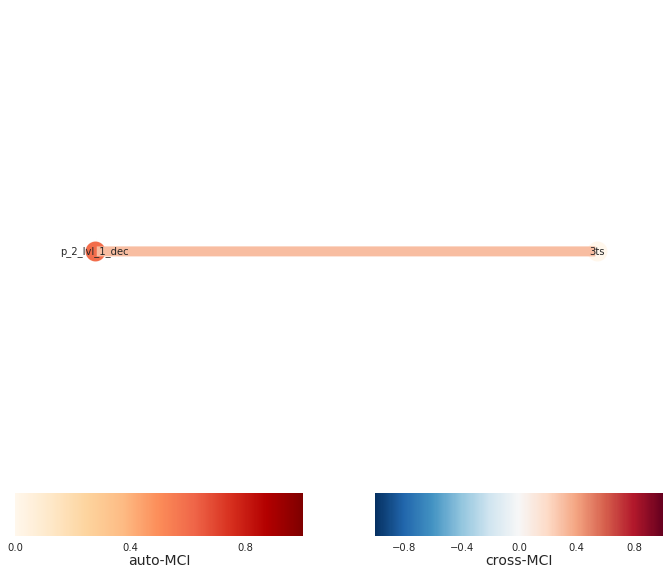

Progress causal inference - traintest set 100%

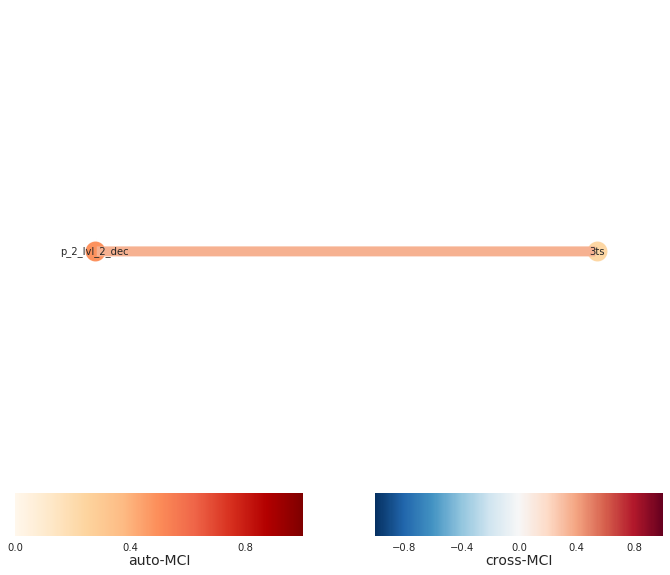

Progress causal inference - traintest set 100%

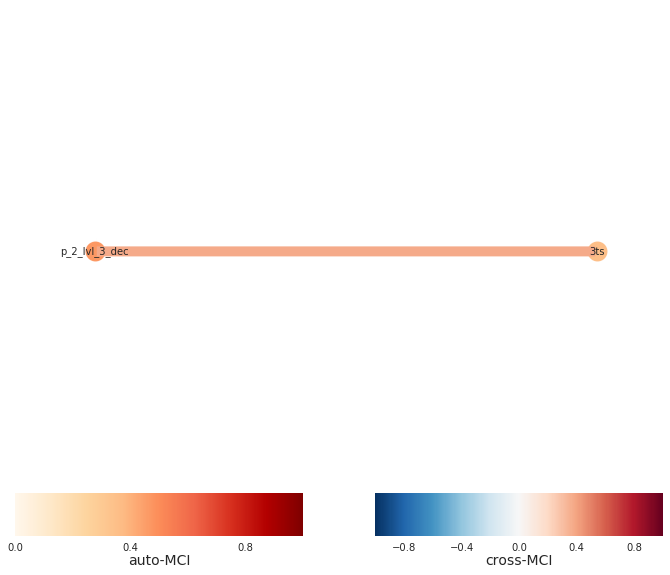

Progress causal inference - traintest set 100%

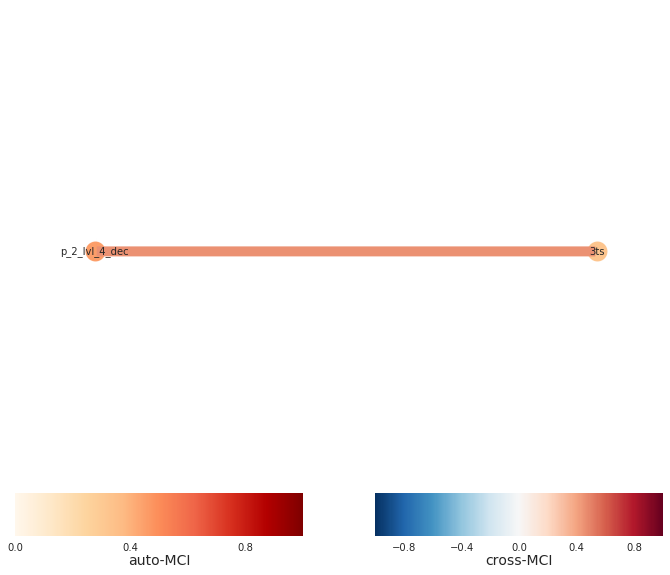

Progress causal inference - traintest set 100%

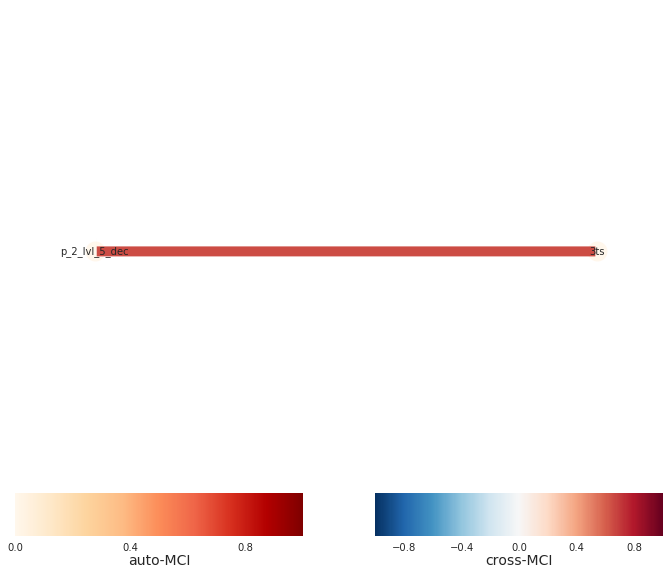

Progress causal inference - traintest set 100%

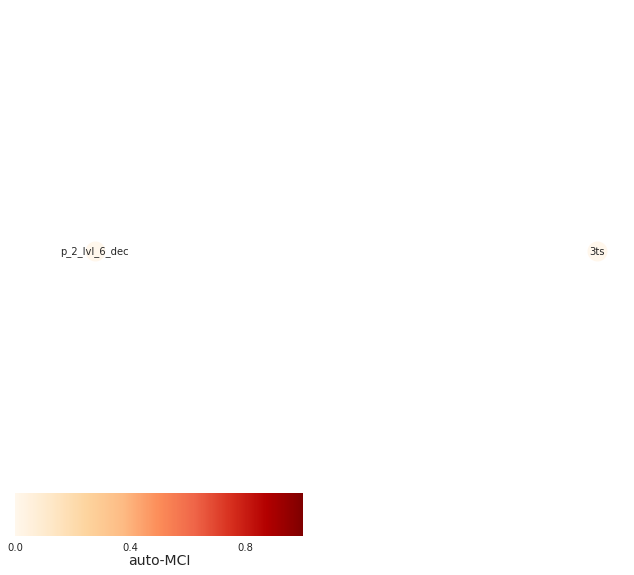

In [19]:
obj_r = []
for i in range(0,len(cA_2)):    
    idx_lvl_t = pd.DatetimeIndex(pd.date_range(rg_index[0] ,end=rg_index[-1], periods=len(cA_t[i]) ).strftime('%Y-%m-%d') )
    idx_prec = pd.DatetimeIndex(pd.date_range(rg_index[0], rg_index[-1], periods=len(cA[i]) ).strftime('%Y-%m-%d') )
    dates = core_pp.get_subdates(dates=idx_lvl_t, start_end_date=('06-15', '08-20'), start_end_year=None, lpyr=False)
    full_time  = idx_lvl_t
    RV_time  = dates
    RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='RV_mask')
    trainIsTrue = pd.Series(np.array([True for _ in range(len(cA_t[i]))]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='TrainIsTrue')
    # ts_ca1 = pd.Series(cA[i], index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_1_lvl_'+ str(i)+'_dec')
    ts_ca2= pd.Series(cA_2[i], index=pd.MultiIndex.from_product(([0], idx_prec)), name='p_2_lvl_'+str(i)+'_dec')
    ts_tca1 = pd.Series(cA_t[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
    df = pd.concat([ts_tca1, ts_ca2, trainIsTrue, RV_mask], axis=1)
    rg.df_data = df
    rg.PCMCI_df_data()
    rg.PCMCI_get_links()
    rg.df_MCIc
    obj_r.append(deepcopy(rg.df_MCIc))
    rg.PCMCI_plot_graph()

In [20]:

x_as = np.arange(0, len(cA_2))
# lag_0 = [np.mean(lags.values[:,0]) for i, lags in enumerate(obj_r)]
# lag_1 = [np.mean(lags.values[:,1]) for _, lags in enumerate(obj_r)]
# plt.figure(figsize=(19,8))
# plt.plot(x_as, lag_0, 'r', label='MCI mean on lag 0')
# plt.plot(x_as, lag_1, 'g', label='MCI mean on lag 1')
# plt.title('Relation MCI on scale wavelet')
# plt.xlabel('Scales')
# plt.ylabel('MCI')
# plt.legend(loc=0)
# plt.show()

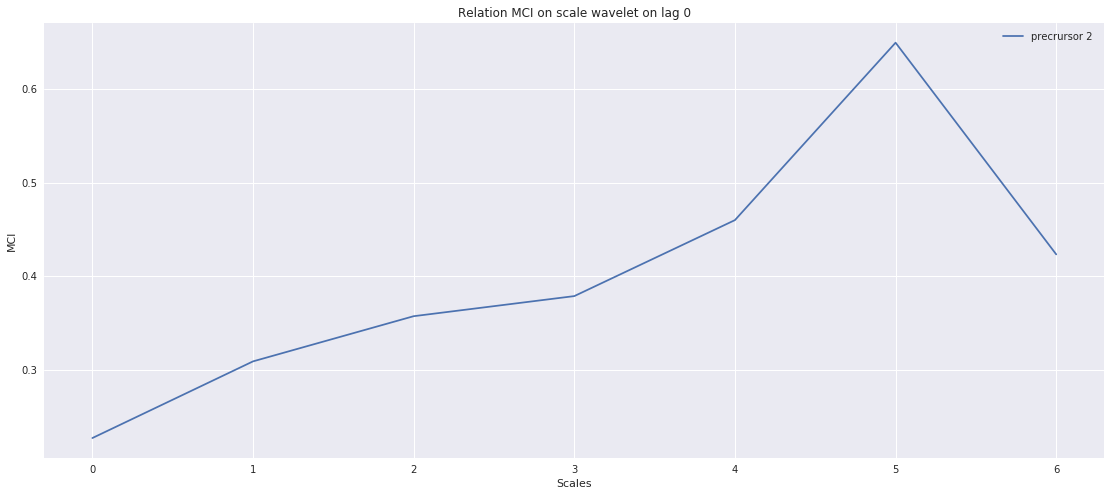

In [38]:
# lag_0_t = [lags.values[:,0][0] for _, lags in enumerate(obj_r)]
lag_0_1 = [lags.values[:,0][1] for _, lags in enumerate(obj_r)]

plt.figure(figsize=(19,8))
# plt.plot(x_as, lag_0_t, label='target ')
plt.plot(x_as, lag_0_1, label='precrursor 2 ')
plt.title('Relation MCI on scale wavelet on lag 0')
plt.xlabel('Scales')
plt.ylabel('MCI')
plt.legend(loc=0)
plt.show()

In [22]:
# def construct_swt(signal, wave, level, norm=False):
#     try:
#         coeffs =  wv.swt(signal, wave, level=level,norm=norm)
#     except ValueError as err :
#         print(err)
#         coeffs =  wv.swt(signal, wave, level=5,norm=norm)
#     ca , cd = [], []
#     for ap, det  in reversed(coeffs):
#         ca.append(ap)
#         cd.append(det)
#     return ca, cd 
# wave  = wv.Wavelet('db4')
# prec1_a, _ = construct_swt(prec1, wave=wave, level=wv.dwt_max_level(len(prec1), wave.dec_len), norm=True)
# prec2_a, _ = construct_swt(prec2, wave=wave, level=wv.dwt_max_level(len(prec2), wave.dec_len), norm=True)
# target_a, _ = construct_swt(target, wave=wave, level=wv.dwt_max_level(len(target), wave.dec_len), norm=True)

In [23]:
# obj_ = []
# for i in range(0,len(prec1_a)):    
#     idx_lvl_t = pd.DatetimeIndex(pd.date_range(rg_index[0] ,end=rg_index[-1], periods=len(target_a[i]) ).strftime('%Y-%m-%d') )
#     idx_prec = pd.DatetimeIndex(pd.date_range(rg_index[0], rg_index[-1], periods=len(prec1_a[i]) ).strftime('%Y-%m-%d') )
#     dates = core_pp.get_subdates(dates=idx_lvl_t, start_end_date=('06-15', '08-20'), start_end_year=None, lpyr=False)
#     full_time  = idx_lvl_t
#     RV_time  = dates
#     RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='RV_mask')
#     trainIsTrue = pd.Series(np.array([True for _ in range(len(target_a[i]))]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='TrainIsTrue')
#     ts_ca1 = pd.Series(prec1_a[i], index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_1_lvl_'+ str(i)+'_dec')
#     ts_ca2= pd.Series(prec2_a[i], index=pd.MultiIndex.from_product(([0], idx_prec)), name='p_2_lvl_'+str(i)+'_dec')
#     ts_tca1 = pd.Series(target_a[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
#     df = pd.concat([ts_tca1, ts_ca1,ts_ca2, trainIsTrue, RV_mask], axis=1)
#     rg.df_data = df

#     obj_.append(rg)
#     rg.PCMCI_df_data()
#     rg.PCMCI_get_links()
#     rg.df_MCIc
#     obj_.append(deepcopy(rg.df_MCIc))
#     rg.PCMCI_plot_graph()

In [24]:
# clean_mci_ = [mci for i, mci in enumerate(obj_) if i % 2 != 0] 
# x_as = np.arange(len(prec1_a))
# lag_0 = [np.mean(lags.values[:,0]) for i, lags in enumerate(clean_mci_)]
# lag_1 = [np.mean(lags.values[:,1]) for _, lags in enumerate(clean_mci_)]

# plt.figure(figsize=(19,8))
# plt.plot(x_as, lag_0, 'r', label='MCI mean on lag 0')
# plt.plot(x_as, lag_1, 'g', label='MCI mean on lag 1')
# plt.title('Relation MCI on scale wavelet')
# plt.xlabel('Scales')
# plt.ylabel('MCI')
# plt.legend(loc=0)
# plt.show()

In [25]:
# lag_0_t = [lags.values[:,0][0] for _, lags in enumerate(clean_mci_)]
# lag_0_1 = [lags.values[:,0][1] for _, lags in enumerate(clean_mci_)]
# lag_0_2 = [lags.values[:,0][2] for _, lags in enumerate(clean_mci_)]

# plt.figure(figsize=(19,8))
# # plt.plot(x_as, lag_0_t, label='target ')
# plt.plot(x_as, lag_0_1, label='precrursor 1 ')
# plt.plot(x_as, lag_0_2, label='precursor 2')
# plt.title('Relation MCI on scale wavelet on lag 0')
# plt.xlabel('Scales')
# plt.ylabel('MCI')
# plt.legend(loc=0)
# plt.show()

In [26]:
# lag_1_t = [lags.values[:,1][0] for _, lags in enumerate(clean_mci_)]
# lag_1_1 = [lags.values[:,1][1] for _, lags in enumerate(clean_mci_)]
# lag_1_2 = [lags.values[:,1][2] for _, lags in enumerate(clean_mci_)]
# plt.figure(figsize=(19,8))
# # plt.plot(x_as, lag_1_t, label='target ')
# plt.plot(x_as, lag_1_1, label='precrursor 1 ')
# plt.plot(x_as, lag_1_2, label='precursor 2')
# plt.title('Relation MCI on scale wavelet on lag 1')
# plt.xlabel('Scales')
# plt.ylabel('MCI')
# plt.legend(loc=0)
# plt.show()

In [27]:
# def upcoef_approx(approx, wave, take_size):
#     return [wv.upcoef('a', app,wave, level=i+1, take=take_size) for i, app in enumerate(approx)]
# up_ca1 = upcoef_approx(cA, wave, take_size=len(prec1))
# up_ca2 = upcoef_approx(cA_2, wave, take_size=len(prec2))
# up_tar = upcoef_approx(cA_t, wave, take_size=len(target))

In [28]:
# obj_ap = []
# for i in range(0,len(up_ca1)):    
#     idx_lvl_t = pd.DatetimeIndex(pd.date_range(rg_index[0] ,end=rg_index[-1], periods=len(up_tar[i]) ).strftime('%Y-%m-%d') )
#     idx_prec = pd.DatetimeIndex(pd.date_range(rg_index[0], rg_index[-1], periods=len(up_ca1[i]) ).strftime('%Y-%m-%d') )
#     dates = core_pp.get_subdates(dates=idx_lvl_t, start_end_date=('06-15', '08-20'), start_end_year=None, lpyr=False)
#     full_time  = idx_lvl_t
#     RV_time  = dates
#     RV_mask = pd.Series(np.array([True if d in RV_time else False for d in full_time]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='RV_mask')
#     trainIsTrue = pd.Series(np.array([True for _ in range(len(up_tar[i]))]), index=pd.MultiIndex.from_product(([0], idx_lvl_t)), name='TrainIsTrue')
#     ts_ca1 = pd.Series(up_ca1[i], index=pd.MultiIndex.from_product(([0], idx_prec)),name='p_1_lvl_'+ str(i)+'_dec')
#     ts_ca2= pd.Series(up_ca2[i], index=pd.MultiIndex.from_product(([0], idx_prec)), name='p_2_lvl_'+str(i)+'_dec')
#     ts_tca1 = pd.Series(up_tar[i], index=pd.MultiIndex.from_product(([0],idx_lvl_t)), name='3ts')
#     df = pd.concat([ts_tca1, ts_ca1,ts_ca2, trainIsTrue, RV_mask], axis=1)
#     rg.df_data = df

#     obj_ap.append(rg)
#     rg.PCMCI_df_data()
#     rg.PCMCI_get_links()
#     rg.df_MCIc
#     obj_ap.append(deepcopy(rg.df_MCIc))
#     rg.PCMCI_plot_graph()

In [29]:
# clean_mci_ap = [mci for i, mci in enumerate(obj_ap) if i % 2 != 0] 
# x_as = np.arange(len(up_ca1))
# lag_0 = [np.mean(lags.values[:,0]) for i, lags in enumerate(clean_mci_ap)]
# lag_1 = [np.mean(lags.values[:,1]) for _, lags in enumerate(clean_mci_ap)]

# plt.figure(figsize=(19,8))
# plt.plot(x_as, lag_0, 'r', label='MCI mean on lag 0')
# plt.plot(x_as, lag_1, 'g', label='MCI mean on lag 1')
# plt.title('Relation MCI on scale wavelet')
# plt.xlabel('Scales')
# plt.ylabel('MCI')
# plt.legend(loc=0)
# plt.show()

In [30]:
# lag_0_t = [lags.values[:,0][0] for _, lags in enumerate(clean_mci_ap)]
# lag_0_1 = [lags.values[:,0][1] for _, lags in enumerate(clean_mci_ap)]
# lag_0_2 = [lags.values[:,0][2] for _, lags in enumerate(clean_mci_ap)]

# plt.figure(figsize=(19,8))
# # plt.plot(x_as, lag_0_t, label='target ')
# plt.plot(x_as, lag_0_1, label='precrursor 1 ')
# plt.plot(x_as, lag_0_2, label='precursor 2')
# plt.title('Relation MCI on scale wavelet on lag 0')
# plt.xlabel('Scales')
# plt.ylabel('MCI')
# plt.legend(loc=0)
# plt.show()

In [31]:
# lag_1_t = [lags.values[:,1][0] for _, lags in enumerate(clean_mci_ap)]
# lag_1_1 = [lags.values[:,1][1] for _, lags in enumerate(clean_mci_ap)]
# lag_1_2 = [lags.values[:,1][2] for _, lags in enumerate(clean_mci_ap)]
# plt.figure(figsize=(19,8))
# # plt.plot(x_as, lag_1_t, label='target ')
# plt.plot(x_as, lag_1_1, label='precrursor 1 ')
# plt.plot(x_as, lag_1_2, label='precursor 2')
# plt.title('Relation MCI on scale wavelet on lag 1')
# plt.xlabel('Scales')
# plt.ylabel('MCI')
# plt.legend(loc=0)
# plt.show()

In [32]:
# def filter_per_scale(signal, wave, alpha,  boundary, mode): # Filtering all subsequent signals
#     s_sign = signal 
#     cA = []
#     cD = []
#     thresh =  alpha * np.nanmax(signal)
#     for i in range(wv.dwt_max_level(len(s_sign), wave.dec_len)): # Using recursion to overwrite signal to go level deepeer
#        s_sign, det =  wv.dwt(s_sign, wave , mode=boundary)
#        s_sign = wv.threshold(s_sign, value=thresh, mode=mode)
#        det = wv.threshold(det, value=(np.nanmax(det) - np.nanmin(det))-np.nanmax(det), mode=mode)
#        cA.append(s_sign)
#        cD.append(det)
#     return cA, cD

In [33]:
# 1/(38*365) 2**7
# print(wave)
# Analysis on ratio noise and signal 

In [34]:
# Makes dependant on either variable when filtering original signal or filtering all signals at all resulting in only small peak
# cA, cD = filter_per_scale(prec1, wave=wave, alpha=0.1, boundary='per', mode='soft') 
# cA_2, cD2 = filter_per_scale(prec2, wave=wave, alpha=0.6,  boundary='per', mode='soft')
# cA_t, cDt = filter_per_scale(target, wave=wave, alpha=0.6, boundary='per', mode='soft')
# fig, ax = plt.subplots(len(cA), 2, figsize=(19, 8))
# fig.suptitle('Using Discrete Wavelet transform', fontsize=18)

# for i in range(len(cA)):
#    ax[i, 0].plot(cA[i], 'r')
#    ax[i, 1].plot(cD[i], 'g')
#    ax[i, 0].set_ylabel('Level {}'.format(i + 1), fontsize=14, rotation=90)
#    if i == 0:
#         ax[i, 0].set_title('Approximation coeffs', fontsize=14)
#         ax[i, 1].set_title('Details coeffs', fontsize=14)
# plt.tight_layout()
# plt.show()

In [35]:
# def filter_per_scale_stat(signal, wave,alpha, mode): # Filtering all subsequent signals
#     cA = []
#     cD = []
#     coeffs = wv.swt(signal, wave, level=5, norm=True)
#     for ap,  det in reversed(coeffs):
#         cA.append(ap)
#         cD.append(det)
#     thresh = alpha * np.nanmax(signal)
#     cA = [wv.threshold(i, value=thresh, mode=mode) for i in cA]
#     cD = [wv.threshold(i, value=thresh, mode=mode) for i in cD]
#     return cA, cD

In [36]:
# ca, cd = filter_per_scale_stat(target, wave=wave,alpha=0.1, mode='soft')
# fig = plt.figure(figsize=(19, 8))
# fig.suptitle('Using Stationary Wavelet transform', fontsize=15)
# w  = wave
# for i, x in enumerate(ca):
#     ax = fig.add_subplot(len(ca) + 1, 2, 1 + i * 2)
#     ax.plot(x, 'r')
#     ax.set_ylabel("A%d" % (i + 1))
#     ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

# for i, x in enumerate(cd):
#     ax = fig.add_subplot(len(cd) + 1, 2, 2 + i * 2)
#     ax.plot(x, 'g')
#     ax.set_ylabel("D%d" % (i + 1))
#     # Scale axes
#     ax.set_xlim(0, len(x) - 1)
#     vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
#     ax.set_ylim(min(0, 2 * min(vals)), max(0, 2 * max(vals)))
# # plt.tight_layout()
# plt.plot()

In [37]:
# print(plt.style.available)
# plt.style.use('dark_background')